In [14]:
import numpy as np
import torch
from env import MultiAgentEnv
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
import pandas as pd
import json
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
from new_env import New_env
import gymnasium as gym
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from joblib import dump, load
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.decomposition import PCA

import xgboost as xgb


from xgboost import XGBClassifier, XGBRegressor


In [3]:
#X_train length 64

X_train = pd.read_csv('/Users/louisedurand-janin/Documents/GitHub/HrFlow_Data_Challenge/data/X_train.csv')
X_train['employee embedding'] = X_train['employee embedding'].apply(lambda x: np.array(json.loads(x), dtype=np.float64))
X_train['company embedding'] = X_train['company embedding'].apply(lambda x: np.array(json.loads(x), dtype=np.float64))

In [4]:
# Y TRAIN
y_train = pd.read_csv('/Users/louisedurand-janin/Documents/GitHub/HrFlow_Data_Challenge/data/y_train.csv', index_col=0)
encoding_map = {
        "Assistant": 0,
        "Executive": 1,
        "Manager": 2,
        "Director": 3,
        
    }

y_train = np.array([encoding_map[category] for category in y_train['position']])

In [166]:
pd.DataFrame(y_train).value_counts()

0
1    17793
0     9023
3     1356
2     1101
Name: count, dtype: int64

In [4]:
# Length 64 !!

# Convert embeddings columns in PyTorch tensors 
employee_embedding_tensor = torch.tensor(np.vstack(X_train['employee embedding'].values), dtype=torch.float64)
company_embedding_tensor = torch.tensor(np.vstack(X_train['company embedding'].values), dtype=torch.float64)

# Concatenate both
combined_tensor = torch.cat([employee_embedding_tensor, company_embedding_tensor], dim=1)

In [5]:
# Length 38 !!
#Reduce company embeddings to length 6 

embeddings_company = np.vstack(X_train['company embedding'].values)


# Création de l'objet PCA pour réduire à 6 dimensions
pca = PCA(n_components=6)

# Fit et transformation des embeddings
reduced_embeddings = pca.fit_transform(embeddings_company)

print(reduced_embeddings.shape) 
# Convert embeddings columns in PyTorch tensors 
employee_embedding_tensor = torch.tensor(np.vstack(X_train['employee embedding'].values), dtype=torch.float64)
company_embedding_tensor = torch.tensor(reduced_embeddings, dtype=torch.float64)

# Concatenate both
combined_tensor = torch.cat([employee_embedding_tensor, company_embedding_tensor], dim=1)
print("combined tensor shape", combined_tensor.shape)

(29273, 6)
combined tensor shape torch.Size([29273, 38])


In [6]:
# TEST 

X_test = pd.read_csv('/Users/louisedurand-janin/Documents/GitHub/HrFlow_Data_Challenge/data/X_train.csv')
X_test['employee embedding'] = X_test['employee embedding'].apply(lambda x: np.array(json.loads(x), dtype=np.float64))
X_test['company embedding'] = X_test['company embedding'].apply(lambda x: np.array(json.loads(x), dtype=np.float64))

In [47]:
# TEST length 64

# Convertir les colonnes d'embeddings en tensors PyTorch
employee_embedding_tensor_test = torch.tensor(np.vstack(X_test['employee embedding'].values), dtype=torch.float64)
company_embedding_tensor_test = torch.tensor(np.vstack(X_test['company embedding'].values), dtype=torch.float64)

# Concaténer les deux tensors le long de la dimension appropriée (axis=1 pour ajouter des colonnes)
combined_tensor_test = torch.cat([employee_embedding_tensor_test, company_embedding_tensor_test], dim=1)

In [7]:
# TEST length 38 

embeddings_company_test = np.vstack(X_test['company embedding'].values)


# Fit et transformation des embeddings
reduced_embeddings_test = pca.transform(embeddings_company_test)

print(reduced_embeddings.shape) 
# Convert embeddings columns in PyTorch tensors 
employee_embedding_tensor_test = torch.tensor(np.vstack(X_test['employee embedding'].values), dtype=torch.float64)
company_embedding_tensor_test = torch.tensor(reduced_embeddings_test, dtype=torch.float64)

# Concatenate both
combined_tensor_test = torch.cat([employee_embedding_tensor_test, company_embedding_tensor_test], dim=1)
print("combined tensor shape", combined_tensor_test.shape)

(29273, 6)
combined tensor shape torch.Size([29273, 38])


In [8]:
# Y TEST
y_test = pd.read_csv("/Users/louisedurand-janin/Documents/GitHub/HrFlow_Data_Challenge/data/y_test.csv", index_col=1)
encoding_map = {
        "Assistant": 0,
        "Executive": 1,
        "Manager": 2,
        "Director": 3,
    }
y_test = np.array([encoding_map[category] for category in y_test['position']])

## OverSampling

In [37]:
ros = RandomOverSampler(random_state=0)
X_oversampled, y_oversampled = ros.fit_resample(combined_tensor, y_train)
X_oversampled, y_oversampled = shuffle(X_oversampled, y_oversampled, random_state=42)

## UnderSampling 

In [40]:
from sklearn.utils import shuffle
from imblearn.under_sampling import NearMiss
undersample = NearMiss(version=1, n_neighbors=3)
X_undersampled, y_undersampled = undersample.fit_resample(np.array(combined_tensor), y_train)
X_undersampled, y_undersampled = shuffle(X_undersampled, y_undersampled, random_state=42)

In [41]:
X_undersampled.shape

(4404, 38)

In [24]:
y_undersampled

array([2, 0, 1, ..., 2, 3, 0])

## Modify embeddings with constrastive learning 

In [62]:
# Contrastive learning model 

class EmbeddingAdjustmentModel(nn.Module):
    def __init__(self, embedding_dim, output_dim):
        super(EmbeddingAdjustmentModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(embedding_dim, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
            nn.ReLU()
        )
        
    def forward(self, x):
        x = self.fc(x)
        return x

In [109]:
combined_tensor_undersampled = torch.tensor(X_undersampled)
embedding_dim = combined_tensor.shape[1]
output_dim = 32
model = EmbeddingAdjustmentModel(embedding_dim, output_dim)
model.load_state_dict(torch.load('/Users/louisedurand-janin/Documents/GitHub/HrFlow_Data_Challenge/model_contrast_32.pt', map_location=torch.device('cpu')))
model.eval()
with torch.no_grad():
    new_embeddings_train = model(combined_tensor)

In [64]:
new_embeddings_train.shape

torch.Size([4404, 32])

In [10]:
def collect_samples(env,  disable_tqdm=False, print_done_states=False):
    s, _ = env.reset(True)
    S = []
    A = []
    rewards = []
    S2 = []
    SA = []
    done= False
    D = []
    #print("s", s)
    #print("true position", env.y[env.index])

    for _ in tqdm(range(env.Emb.shape[0]-1), disable=disable_tqdm):
        #print("index", env.index)
        #print(len(S))
        while done==False:
            a = env.sample_action()
            s2, emb2s2, r, done, _ = env.step(a)
            #print("next state preidcted", s2)
            #print("next embedding state ", emb2s2)
            S.append(s)
            #print('shape S', len(S))
            A.append(a)
            sa = torch.cat([s, torch.tensor(a)])
            SA.append(sa)
            rewards.append(r)
            #print("reward", r)
            S2.append(emb2s2)
            D.append(done)
            #if done:
                #s, _ = env.reset(False)
                #print("new embedding", s)
                #print("true position", env.y[env.index])
                #print("done!")
            #else:
            s = emb2s2
        s, _ = env.reset(False)
        done = False
    S2 = np.array(S2)
    S = np.array(S)
    A = np.array(A)
    D = np.array(D)
    SA = np.array(SA)
    rewards = np.array(rewards)
    return S, A, rewards, S2, D, SA

In [11]:
env = New_env(combined_tensor, y_train)
S, A, R, S2, D, SA = collect_samples(env)

  0%|          | 0/29272 [00:00<?, ?it/s]

/var/folders/hz/p_k7b1g12kz9ykb1cx0n70w00000gn/T/ipykernel_54388/2316599510.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sa = torch.cat([s, torch.tensor(a)])
100%|██████████| 29272/29272 [00:49<00:00, 592.00it/s] 


In [52]:
env.Emb.shape[0]

4404

In [53]:
R.shape

(26285,)

In [15]:
D.flatten()

array([False, False, False, ..., False, False,  True])

In [15]:
def rf_fqi(S, A, R, S2, D, SA, iterations, nb_actions=2, gamma=0.9, disable_tqdm=False):
    nb_samples = S.shape[0]
    Qfunctions = []
    #SA = np.append(S,A,axis=1)
    for iter in tqdm(range(iterations), disable=disable_tqdm):
        #print("iteration", iter)
        if iter==0:
            value=R.copy()
        else:
            Q2 = np.zeros((nb_samples,nb_actions))
            for a2 in range(nb_actions):
                A2 = torch.full((S2.shape[0], 1), a2)
                #print(A2.shape)
                S2A2 = torch.cat([torch.from_numpy(S2), A2], dim=1)
                S2A2_array = np.array(S2A2)
                #print("shaoe A2S2", S2A2_array.shape)
                predictions = Qfunctions[-1].predict(S2A2_array)
                #print("shape pred", predictions.shape)
                Q2[:,a2] = Qfunctions[-1].predict(S2A2_array)
            max_Q2 = np.max(Q2,axis=1)
            #print("max Q2",max_Q2[:10])
            print(np.dot((1-D.flatten()),max_Q2))
            value = R + gamma*(1-D.flatten())*max_Q2
            #print("cumulated reward", value)
            #print("value", value.shape)
        Q = XGBRegressor()
        Q.fit(SA,value)
        #print("cumulated reward", value)
        Qfunctions.append(Q)
    return Qfunctions

In [16]:
qfunctions = rf_fqi(S, A, R, S2, D, SA, 10)

 10%|█         | 1/10 [00:03<00:33,  3.70s/it]

-26742.651432616054


 20%|██        | 2/10 [00:08<00:36,  4.60s/it]

-9081.41293703951


 30%|███       | 3/10 [00:12<00:29,  4.18s/it]

9569.657403488061


 40%|████      | 4/10 [00:16<00:23,  3.98s/it]

26446.673407736234


 50%|█████     | 5/10 [00:20<00:19,  3.92s/it]

41015.70767913805


 60%|██████    | 6/10 [00:24<00:15,  3.92s/it]

54144.00813992316


 70%|███████   | 7/10 [00:27<00:11,  3.90s/it]

65461.29393131286


 80%|████████  | 8/10 [00:31<00:07,  3.90s/it]

75893.51113826537


 90%|█████████ | 9/10 [00:35<00:03,  3.91s/it]

87021.18077568233


100%|██████████| 10/10 [00:39<00:00,  3.96s/it]


In [17]:

def greedy_action(Q,s,nb_actions=2):
    Qsa = []
    for a in range(nb_actions):
        #print("s", s)
        #print("a", torch.tensor([a]))
        sa = torch.cat([s, torch.tensor([a])], dim=0)
        sa = np.array(sa)
        #print(sa.reshape(-1,1).shape)
        #print("prediction", Q.predict(sa.reshape(1, -1)))
        Qsa.append(Q.predict(sa.reshape(1, -1)))
    #print("Qsa", Qsa)
    return np.argmax(Qsa)

In [21]:
career_env_test = New_env(combined_tensor, y_train)
pred=[]
y_pred = []
s,_ =  career_env_test.reset(True)
i=0
#for t in tqdm(range(len(y_test))):
for t in tqdm(range(len(y_train))):
    for k in range(10):
        a = greedy_action(qfunctions[-1],s)

        predicted_next_position, predicted_next_emb_state, reward, d, _ = career_env_test.step(a)

        s = predicted_next_emb_state
        if t in [0,1,2,3]:
            print("action chosen", a)

            print("s", predicted_next_position)
            print("target", y_train[i])
        #if a ==0:
         #   break
        
        if d:
            break
    i+=1
    pred.append(s)
    y_pred.append(predicted_next_position.item())
    s,_=career_env_test.reset(False)

  0%|          | 0/29273 [00:00<?, ?it/s]

action chosen 1
s tensor([1.])
target 1
action chosen 0
s tensor([1.])
target 1
action chosen 0
s tensor([1.])
target 1
action chosen 0
s tensor([1.])
target 1
action chosen 0
s tensor([1.])
target 1
action chosen 0
s tensor([1.])
target 1
action chosen 0
s tensor([1.])
target 1
action chosen 0
s tensor([1.])
target 1


  0%|          | 2/29273 [00:00<1:39:17,  4.91it/s]

action chosen 0
s tensor([1.])
target 1
action chosen 0
s tensor([1.])
target 1
action chosen 1
s tensor([1.])
target 1
action chosen 0
s tensor([1.])
target 1
action chosen 0
s tensor([1.])
target 1
action chosen 0
s tensor([1.])
target 1
action chosen 0
s tensor([1.])
target 1
action chosen 0
s tensor([1.])
target 1
action chosen 0
s tensor([1.])
target 1
action chosen 0
s tensor([1.])
target 1
action chosen 0
s tensor([1.])
target 1
action chosen 0
s tensor([1.])
target 1
action chosen 0
s tensor([0.])
target 1
action chosen 0
s tensor([0.])
target 1
action chosen 0
s tensor([0.])
target 1


  0%|          | 3/29273 [00:00<1:30:15,  5.40it/s]

action chosen 0
s tensor([0.])
target 1
action chosen 0
s tensor([0.])
target 1
action chosen 0
s tensor([0.])
target 1
action chosen 0
s tensor([0.])
target 1
action chosen 0
s tensor([0.])
target 1
action chosen 0
s tensor([0.])
target 1
action chosen 0
s tensor([0.])
target 1
action chosen 0
s tensor([0.])
target 1
action chosen 0
s tensor([0.])
target 1
action chosen 0
s tensor([0.])
target 1
action chosen 0
s tensor([0.])
target 1
action chosen 0
s tensor([0.])
target 1
action chosen 0
s tensor([0.])
target 1
action chosen 0
s tensor([0.])
target 1
action chosen 0
s tensor([0.])
target 1
action chosen 0
s tensor([0.])
target 1
action chosen 0
s 

  0%|          | 5/29273 [00:00<1:01:55,  7.88it/s]

tensor([0.])
target 1


100%|█████████▉| 29272/29273 [08:28<00:00, 57.60it/s] 


IndexError: index 29273 is out of bounds for dimension 0 with size 29273

In [135]:
pd.DataFrame(y_pred).value_counts()



0  
0.0    2817
3.0     861
2.0     435
1.0     291
Name: count, dtype: int64

In [136]:
f1_score(y_pred, y_undersampled, average="macro")

0.3992018691841165

In [122]:
class DQN(nn.Module):
    def __init__(self, input_size, hidden_size, nb_actions):
        super(DQN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, nb_actions)
        )
    
    def forward(self, x):
        return self.network(x)


def rf_fqi(S, A, R, S2, D, SA, iterations, nb_actions=2, gamma=0.9, disable_tqdm=False):
    nb_samples = S.shape[0]
    Qfunctions = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_size = SA.shape[1]
    hidden_size = 128  # Example size
    model = DQN(input_size, hidden_size, 1).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    #SA = np.append(S,A,axis=1)
    for iter in tqdm(range(iterations), disable=disable_tqdm):
        #print("iteration", iter)
        if iter==0:
            value=R.copy()
        else:
            Q2 = np.zeros((nb_samples,nb_actions))
            for a2 in range(nb_actions):
                A2 = torch.full((S2.shape[0], 1), a2)
                #print(A2.shape)
                S2A2 = torch.cat([torch.from_numpy(S2), A2], dim=1)
                S2A2_array = np.array(S2A2)
                #print("shaoe A2S2", S2A2_array.shape)
                predictions = model(S2A2)
                #print("shape pred", predictions.shape)
                print(Q2.shape)
                print(predictions.shape)
                Q2[:,a2] = predictions.detach().squeeze()
            max_Q2 = np.max(Q2,axis=1)
            #print("max Q2",max_Q2[:10])
            print(np.dot((1-D.flatten()),max_Q2))
            value = R + gamma*(1-D.flatten())*max_Q2
            #print("cumulated reward", value)
            #print("value", value.shape)
        # Prepare SA and value for training
        SA_tensor = torch.from_numpy(SA).float().to(device)
        value_tensor = torch.from_numpy(value).float().to(device)
        print(SA_tensor.shape)
        # Train DNN
        #print("value",value.shape)
        optimizer.zero_grad()
        model = model.double()
        predictions = model(SA_tensor.double()).squeeze()
        print(predictions.shape)
        loss = criterion(predictions.double(), value_tensor.double())
        loss.backward()
        optimizer.step()
        torch.save(model, 'model_FQI_deep.pt')
        #print("cumulated reward", value)
        #Qfunctions.append(Q)
    return model.state_dict

In [123]:
model_dict = rf_fqi(S, A, R, S2, D, SA, 10)

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:00<00:01,  6.73it/s]

torch.Size([26285, 40])
value (26285,)
torch.Size([26285])
(26285, 2)
torch.Size([26285, 1])
(26285, 2)
torch.Size([26285, 1])
-719.408304661079
value (26285,)
torch.Size([26285, 40])
value (26285,)
torch.Size([26285])


 30%|███       | 3/10 [00:00<00:01,  4.58it/s]

(26285, 2)
torch.Size([26285, 1])
(26285, 2)
torch.Size([26285, 1])
-1771.6366432190007
value (26285,)
torch.Size([26285, 40])
value (26285,)
torch.Size([26285])
(26285, 2)
torch.Size([26285, 1])


 40%|████      | 4/10 [00:00<00:01,  4.42it/s]

(26285, 2)
torch.Size([26285, 1])
-2816.581003465987
value (26285,)
torch.Size([26285, 40])
value (26285,)
torch.Size([26285])
(26285, 2)
torch.Size([26285, 1])


 50%|█████     | 5/10 [00:01<00:01,  4.48it/s]

(26285, 2)
torch.Size([26285, 1])
-3855.633643325138
value (26285,)
torch.Size([26285, 40])
value (26285,)
torch.Size([26285])
(26285, 2)
torch.Size([26285, 1])


 60%|██████    | 6/10 [00:01<00:00,  4.49it/s]

(26285, 2)
torch.Size([26285, 1])
-4890.331437044628
value (26285,)
torch.Size([26285, 40])
value (26285,)
torch.Size([26285])
(26285, 2)
torch.Size([26285, 1])
(26285, 2)
torch.Size([26285, 1])
-5922.649880416283
value (26285,)
torch.Size([26285, 40])
value (26285,)
torch.Size([26285])


 70%|███████   | 7/10 [00:01<00:00,  3.52it/s]

(26285, 2)
torch.Size([26285, 1])
(26285, 2)
torch.Size([26285, 1])
-6954.092254589528
value (26285,)
torch.Size([26285, 40])
value (26285,)
torch.Size([26285])


 80%|████████  | 8/10 [00:02<00:00,  3.41it/s]

(26285, 2)
torch.Size([26285, 1])
(26285, 2)
torch.Size([26285, 1])
-7986.394903772739
value (26285,)
torch.Size([26285, 40])
value (26285,)
torch.Size([26285])


 90%|█████████ | 9/10 [00:02<00:00,  3.25it/s]

(26285, 2)
torch.Size([26285, 1])
(26285, 2)
torch.Size([26285, 1])
-9021.09588889922
value (26285,)
torch.Size([26285, 40])
value (26285,)
torch.Size([26285])


100%|██████████| 10/10 [00:02<00:00,  3.68it/s]


In [124]:
input_size = SA.shape[1]
hidden_size = 128  # Example size
device="cpu"
modele = DQN(input_size, hidden_size, 1).to(device)

modele.load_state_dict(torch.load('/Users/louisedurand-janin/Documents/GitHub/HrFlow_Data_Challenge/model_FQI_deep.pt'))
modele.eval() 

TypeError: Expected state_dict to be dict-like, got <class '__main__.DQN'>.

In [ ]:
def greedy_action(network, state):
    device = "cuda" if next(network.parameters()).is_cuda else "cpu"
    with torch.no_grad():
        Q = network(torch.Tensor(state).unsqueeze(0).to(device))
        #print("Q", Q)
        return torch.argmax(Q).item()

In [ ]:
career_env_test = New_env(torch.tensor(X_undersampled, dtype=torch.float64), torch.tensor(y_undersampled, dtype=torch.float64))
pred=[]
y_pred = []
s,_ =  career_env_test.reset(True)
i=0
#for t in tqdm(range(len(y_test))):
for t in tqdm(range(len(y_undersampled))):
    for k in range(5):
        a = greedy_action(modele,s)

        predicted_next_position, predicted_next_emb_state, reward, d, _ = career_env_test.step(a)

        s = predicted_next_emb_state
        if t in [0,1,2,3]:
            print("action chosen", a)

            print("s", predicted_next_position)
            print("target", y_undersampled[i])
        #if a ==0:
         #   break
        
        if d:
            break
    i+=1
    pred.append(s)
    y_pred.append(predicted_next_position.item())
    s,_=career_env_test.reset(False)

In [132]:

def greedy_action(Q,s,nb_actions=2):
    Qsa = []
    for a in range(nb_actions):
        #print("s", s)
        #print("a", torch.tensor([a]))
        sa = torch.cat([s, torch.tensor([a])], dim=0)
        sa = np.array(sa)
        #print(sa.reshape(-1,1).shape)
        #print("prediction", Q.predict(sa.reshape(1, -1)))
        Qsa.append(Q.predict(sa.reshape(1, -1)))
    #print("Qsa", Qsa)
    return np.argmax(Qsa)

In [35]:
combined_tensor

tensor([[ 0.0133, -0.3762, -0.6138,  ..., -0.4219, -0.3206, -0.4043],
        [-0.2827, -0.0129,  0.2054,  ..., -0.1548,  0.0759, -0.6390],
        [ 0.4000, -0.2985, -0.2110,  ..., -0.5598,  0.1031, -0.1492],
        ...,
        [-0.2505, -0.2068,  0.5609,  ..., -0.1784, -0.3287, -0.4991],
        [-0.2505, -0.2068,  0.5609,  ..., -0.8119,  0.0043,  0.2834],
        [-0.6191, -0.0630, -0.2045,  ..., -0.3501, -0.6396, -0.5535]])

In [57]:
pred=[]
y_pred = []
s,_ =  env.reset(True)

for t in tqdm(range(4404)):
    stay_a = 0
    dbis=False
    for k in range(6):
    
        
        a = greedy_action(qfunctions[-1],s)
        if a ==0:
            stay_a+=1
            if stay_a==2:
                dbis=True
        predicted_next_position, predicted_next_emb_state, reward, d, _ = env.step(a)
        #print("s", s)
        s = predicted_next_emb_state

        if d or dbis:
            break
    pred.append(s)
    #print(len(pred))
    y_pred.append(predicted_next_position.item())
    s,_=env.reset(False)


100%|█████████▉| 4403/4404 [05:54<00:00, 12.41it/s]


IndexError: index 4404 is out of bounds for dimension 0 with size 4404

In [58]:
print(len(y_pred))

4404


In [26]:
y_undersampled

array([0, 0, 0, ..., 3, 3, 3])

In [35]:
print(pd.DataFrame(y_undersampled).value_counts())

0
0    1101
1    1101
2    1101
3    1101
Name: count, dtype: int64


In [59]:
print(pd.DataFrame(y_pred).value_counts())

0  
0.0    2299
1.0    1089
2.0     679
3.0     337
Name: count, dtype: int64


In [83]:
print(pd.DataFrame(y_pred).value_counts())

0  
0.0    1706
1.0    1266
2.0    1007
3.0     425
Name: count, dtype: int64


In [32]:
y_train

array([1, 1, 1, ..., 1, 1, 1])

In [60]:
print(f1_score(y_pred, y_undersampled, average="macro"))
print(accuracy_score(y_pred, y_undersampled))

0.6405329994259156
0.653496821071753


In [93]:
combined_tensor_undersampled = torch.tensor(X_undersampled)
embedding_dim = combined_tensor_test.shape[1]
output_dim = 32
model = EmbeddingAdjustmentModel(embedding_dim, output_dim)
model.load_state_dict(torch.load('/Users/louisedurand-janin/Documents/GitHub/HrFlow_Data_Challenge/model_contrast_32.pt', map_location=torch.device('cpu')))
model.eval()
model = model.double() 
with torch.no_grad():
    new_embeddings_test = model(combined_tensor_test)

In [64]:
career_env_test = New_env(combined_tensor_test, torch.tensor(y_test))

In [62]:
len(y_test)

7327

In [65]:
pred=[]
y_pred = []
s,_ =  career_env_test.reset(True)

for t in tqdm(range(len(y_test))):
    stay_a = 0
    dbis=False
    for k in range(6):
        a = greedy_action(qfunctions[-1],s)
        if a==0:
            stay_a+=1
            if stay_a ==2:
                dbis=True
        predicted_next_position, predicted_next_emb_state, reward, d, _ = career_env_test.step(a)
        #print("s", s)
        s = predicted_next_emb_state

        if d or dbis:
            break
    pred.append(s)
    y_pred.append(predicted_next_position.item())
    s,_=career_env_test.reset(False)

  0%|          | 0/7327 [00:00<?, ?it/s]

100%|██████████| 7327/7327 [06:13<00:00, 19.62it/s]


In [66]:
print(pd.DataFrame(y_pred).value_counts())

0  
0.0    5770
1.0     767
2.0     716
3.0      74
Name: count, dtype: int64


In [138]:
print(f1_score(y_pred, y_test, average="macro"))
print(accuracy_score(y_pred, y_test))

0.19295223120591057
0.24457486010645557


In [47]:
print(f1_score(y_pred, y_test, average="macro"))
print(accuracy_score(y_pred, y_test))

0.2369557828085949
0.255766343660434


In [97]:
print(f1_score(y_pred, y_test, average="macro"))
print(accuracy_score(y_pred, y_test))

0.20596223086716942
0.24498430462672308


In [67]:
print(f1_score(y_pred, y_test, average="macro"))
print(accuracy_score(y_pred, y_test))

0.17024343425581262
0.2537191210590965


In [98]:
y_test_real = pd.read_csv("/Users/louisedurand-janin/Documents/GitHub/HrFlow_Data_Challenge/data/y_test.csv", index_col=0)

In [99]:
encoding_map = {
        0: "Assistant",
        1:"Executive",
        2:"Manager",
        3 :"Director",
    }
y_pred_encoded = np.array([encoding_map[category] for category in y_pred])

In [100]:

y_test_real.drop(['position'], axis=1, inplace=True)
y_test_real["position"] = y_pred_encoded

y_test_real

,id,position
0,29273,Executive
1,29274,Executive
2,29275,Executive
3,29276,Director
4,29277,Executive
...,...,...
7322,36595,Assistant
7323,36596,Assistant
7324,36597,Executive
7325,36598,Assistant


In [53]:
y_test_real

,id,position
0,29273,Manager
1,29274,Assistant
2,29275,Executive
3,29276,Manager
4,29277,Manager
...,...,...
7322,36595,Manager
7323,36596,Assistant
7324,36597,Executive
7325,36598,Manager


In [104]:
y_test_real.to_csv('soumission_contrastive.csv', index=True)

Text(0.5, 25.722222222222214, 'Predicted label')

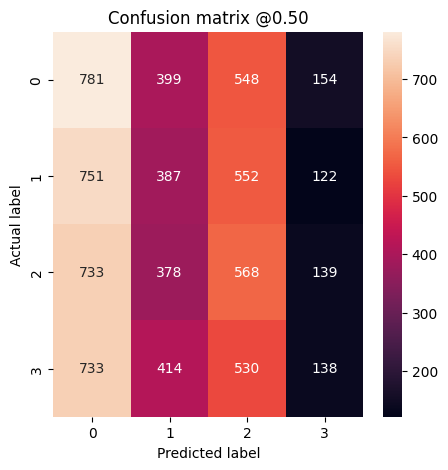

In [60]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix @{:.2f}'.format(0.5))
plt.ylabel('Actual label')
plt.xlabel('Predicted label')